# Preprocessing

### Dataset
- Dataset source: https://www.data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan
- Last Updated in 23 August 2022 by the Department for Transport

### Methodology
- Using Schneiderman's Mantra to approach the Visual Analytics Process

## 1. Overview of Data

In [28]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# An overview of the NaPTAN dataset
stops_data = pd.read_csv('../data/raw/stops.csv', low_memory = False)
stops_data.info()
stops_data.describe()
stops_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435046 entries, 0 to 435045
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ATCOCode                 435046 non-null  object 
 1   NaptanCode               409329 non-null  object 
 2   PlateCode                62938 non-null   object 
 3   CleardownCode            0 non-null       float64
 4   CommonName               435046 non-null  object 
 5   CommonNameLang           0 non-null       float64
 6   ShortCommonName          96644 non-null   object 
 7   ShortCommonNameLang      0 non-null       float64
 8   Landmark                 251191 non-null  object 
 9   LandmarkLang             0 non-null       float64
 10  Street                   411203 non-null  object 
 11  StreetLang               0 non-null       float64
 12  Crossing                 0 non-null       float64
 13  CrossingLang             0 non-null       float64
 14  Indi

,ATCOCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,...,TimingStatus,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
0,0100BRP90310,bstgwpa,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2023-04-21T18:02:19,99.0,new,active
1,0100BRP90311,bstgwpm,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2019-09-13T10:41:38,73.0,new,active
2,10000056,bstpjgw,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2019-08-06T00:00:00,2019-08-06T11:09:11,120.0,new,active
3,0100BRP90312,bstjaja,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:23:29,45.0,new,active
4,0100BRP90313,bstjama,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:22:13,44.0,new,active


## 2. Zoom and Filter (And using Overview at the end of stages)

#### a. Handling Missing and Conflicting Values

##### The "Modification" and "Status" columns
- I want to define rules to handle the rows that have the values: delete, inactive and pending. I'm doing this because the dataset should represent active stops.
- I will keep the rows with the "pending" value but treat this as a potential limitation, because of the maintenance records. This might change depending on the results.

In [30]:
# Dropping the rows with 'delete' and 'inactive' string values
stops_data = stops_data[~((stops_data['Modification'] == 'delete') & (stops_data['Status'] == 'inactive'))]

# Check the number of rows removed
initial_minus_first_column = 435045
print(f"Rows removed: {initial_minus_first_column - stops_data.shape[0]}")

Rows removed: 17935


In [31]:
# Displaying the ratio of missing values in features (0 for no missing values)
missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

DefaultWaitTime            1.000000
Notes                      1.000000
IndicatorLang              1.000000
CrossingLang               1.000000
Crossing                   1.000000
StreetLang                 1.000000
LandmarkLang               1.000000
GrandParentLocalityName    1.000000
ShortCommonNameLang        1.000000
CommonNameLang             1.000000
NotesLang                  1.000000
CleardownCode              1.000000
SuburbLang                 0.972952
TownLang                   0.964678
PlateCode                  0.849222
Suburb                     0.829594
ShortCommonName            0.772012
Town                       0.638520
ParentLocalityName         0.563698
Landmark                   0.414246
Latitude                   0.125600
Longitude                  0.125600
Modification               0.084695
Indicator                  0.055501
Street                     0.054997
Bearing                    0.053240
NaptanCode                 0.046932
BusStopType                0

##### The "LocalityCentre" column
- This column of an object data type has mixed values (i.e. TRUE, FALSE, 1, 0)
- These columns need to be consistent (i.e. True, False).

In [32]:
stops_data['LocalityCentre'] = stops_data['LocalityCentre'].map({'TRUE' : True, '1' : True, 'FALSE' : False, 
                                                                 '0' : False})

**2nd ITERATION - The "LocalityCentre" column**
- Converting the column now 
- Using the astype() method to change this column to a bool as they now contain consistent **True** and **False** values.
- This is good for the logical aspects of analysis and to make it easier for human reasoning.
- Source: https://www.w3schools.com/python/pandas/ref_df_astype.asp

In [33]:
stops_data['LocalityCentre'] = stops_data['LocalityCentre'].astype('bool')

##### Missing Geographical Data
- Identify the rows with the missing geospatial data
- Then separate the missing geospatial data for analysis (It may be useful later, or if we having an imputation solution)

In [34]:
# Checking how many rows with missing geospatial data
missing_geo_data = stops_data[stops_data['Longitude'].isna() | 
stops_data['Latitude'].isna()]
print(f"Rows with missing geospatial data: {missing_geo_data.shape[0]}")

# Separate geospatial data for analysis
stops_data = stops_data.dropna(subset = ['Longitude', 'Latitude'])
stops_data_without_geo = stops_data[stops_data['Longitude'].isna() & stops_data['Latitude'].isna()]

Rows with missing geospatial data: 52389


##### General Missing Values
- So far, 52389 rows have been removed due to missing geospatial data. Time to look at the columns.
- There are lot of missing values in the columns. Some of them are understandable but I want to get a clearer picture of which columns to remove
- I will remove the columns whose values are missing by 40% to 60%. 

In [35]:
# Displaying the ratio of missing values in features (0 for no missing values)
missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

StreetLang                 1.000000
IndicatorLang              1.000000
CleardownCode              1.000000
DefaultWaitTime            1.000000
CommonNameLang             1.000000
GrandParentLocalityName    1.000000
ShortCommonNameLang        1.000000
LandmarkLang               1.000000
NotesLang                  1.000000
Crossing                   1.000000
CrossingLang               1.000000
Notes                      1.000000
SuburbLang                 0.969067
TownLang                   0.959605
PlateCode                  0.827570
Suburb                     0.817115
ShortCommonName            0.753516
Town                       0.691452
ParentLocalityName         0.566562
Landmark                   0.421580
Street                     0.062393
Indicator                  0.060279
Bearing                    0.056490
NaptanCode                 0.050809
BusStopType                0.043976
Modification               0.042698
TimingStatus               0.037774
RevisionNumber             0

- Therefore, there are 20 columns to remove. They are not critical for analysis in regards to the research question about rural vs urban.

In [36]:
# Calculating the percentages of missing values per column
missing_percent = stops_data.isnull().mean() * 100

# Displaying the column with missing values
missing_percent_final = missing_percent.sort_values(ascending = False)

# The threshold for removal is set to 40% missing data
columns_to_drop = missing_percent_final[missing_percent_final > 40].index

# Removing the columns
stops_data = stops_data.drop(columns = columns_to_drop)

# Displaying the removal and what columns remain
print(f"Count of columns removed who had >40% missing values: {list(columns_to_drop)}")
print(f"Columns remaining: {stops_data.columns}")
print(f"Rows and Columns remaining: {stops_data.shape}")


missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

Count of columns removed who had >40% missing values: ['StreetLang', 'IndicatorLang', 'CleardownCode', 'DefaultWaitTime', 'CommonNameLang', 'GrandParentLocalityName', 'ShortCommonNameLang', 'LandmarkLang', 'NotesLang', 'Crossing', 'CrossingLang', 'Notes', 'SuburbLang', 'TownLang', 'PlateCode', 'Suburb', 'ShortCommonName', 'Town', 'ParentLocalityName', 'Landmark']
Columns remaining: Index(['ATCOCode', 'NaptanCode', 'CommonName', 'Street', 'Indicator',
       'Bearing', 'NptgLocalityCode', 'LocalityName', 'LocalityCentre',
       'GridType', 'Easting', 'Northing', 'Longitude', 'Latitude', 'StopType',
       'BusStopType', 'TimingStatus', 'AdministrativeAreaCode',
       'CreationDateTime', 'ModificationDateTime', 'RevisionNumber',
       'Modification', 'Status'],
      dtype='object')
Rows and Columns remaining: (364721, 23)
Street                    0.062393
Indicator                 0.060279
Bearing                   0.056490
NaptanCode                0.050809
BusStopType             

- After removing the columns with more than 40% missing values and separating 52389 rows of missing geospatial data, the current column with the highest missing values is the "Street" column with 6.2%. This is very low, and a positive result.


In [37]:
stops_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364721 entries, 0 to 435045
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ATCOCode                364721 non-null  object 
 1   NaptanCode              346190 non-null  object 
 2   CommonName              364721 non-null  object 
 3   Street                  341965 non-null  object 
 4   Indicator               342736 non-null  object 
 5   Bearing                 344118 non-null  object 
 6   NptgLocalityCode        364721 non-null  object 
 7   LocalityName            364721 non-null  object 
 8   LocalityCentre          364721 non-null  bool   
 9   GridType                362845 non-null  object 
 10  Easting                 364721 non-null  int64  
 11  Northing                364721 non-null  int64  
 12  Longitude               364721 non-null  float64
 13  Latitude                364721 non-null  float64
 14  StopType            

In [38]:
stops_data.head()

,ATCOCode,NaptanCode,CommonName,Street,Indicator,Bearing,NptgLocalityCode,LocalityName,LocalityCentre,GridType,...,Latitude,StopType,BusStopType,TimingStatus,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
0,0100BRP90310,bstgwpa,Temple Meads Stn,Redcliffe Way,T3,E,N0077020,Temple Meads,False,UKOS,...,51.44902,BCT,MKD,OTH,9,2009-08-25T00:00:00,2023-04-21T18:02:19,99.0,new,active
1,0100BRP90311,bstgwpm,Temple Meads Stn,Victoria Street,T7,NW,N0077020,Temple Meads,False,UKOS,...,51.45014,BCT,MKD,OTH,9,2009-08-25T00:00:00,2019-09-13T10:41:38,73.0,new,active
2,10000056,bstpjgw,Temple Meads Stn,Temple Gate,T2,N,N0077020,Temple Meads,False,UKOS,...,51.44967,BCT,MKD,OTH,9,2019-08-06T00:00:00,2019-08-06T11:09:11,120.0,new,active
3,0100BRP90312,bstjaja,Temple Meads Stn,Station Approach,T6,NE,N0077020,Temple Meads,False,UKOS,...,51.44898,BCT,MKD,OTH,9,2009-08-25T00:00:00,2020-11-26T13:23:29,45.0,new,active
4,0100BRP90313,bstjama,Temple Meads Stn,Station Approach,T5,NE,N0077020,Temple Meads,False,UKOS,...,51.44944,BCT,MKD,OTH,9,2009-08-25T00:00:00,2020-11-26T13:22:13,44.0,new,active


**2nd Iteration**
I want to check display some of the rows where RevisionNumber is NaN. I want to see if there are any patterns

In [39]:
missing_revision_rows = stops_data[stops_data['RevisionNumber'].isnull()]
print(f"Number of rows with missing RevisionNumber: {len(missing_revision_rows)}")
missing_revision_rows

Number of rows with missing RevisionNumber: 5513


,ATCOCode,NaptanCode,CommonName,Street,Indicator,Bearing,NptgLocalityCode,LocalityName,LocalityCentre,GridType,...,Latitude,StopType,BusStopType,TimingStatus,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
32799,0690WNA02952,wrgmpmg,Penketh High School,Heath Road,o/s,E,E0053808,Penketh,True,NaN,...,53.387517,BCT,MKD,OTH,63,2019-04-08T11:27:29,2019-04-08T11:19:38,NaN,new,active
32800,0690WNA02953,wrgmpmj,Warrington Vale Royal College,Long Lane,Entance,NaN,E0043038,Orford,True,NaN,...,53.407577,BCE,NaN,NaN,63,2019-04-08T11:40:53,2019-04-08T11:33:38,NaN,new,active
32801,0690WNA02954,wrgmpmp,Hinton House,Birchwood Park Avenue,O/S,S,E0053799,Birchwood,True,NaN,...,53.427001,BCT,MKD,OTH,63,2019-11-26T13:44:15,2019-11-26T13:39:23,NaN,new,active
32808,0690WNA02961,wrgmpwp,ASDA Omega,Omega Boulevard,o\s,W,E0053805,Great Sankey,True,NaN,...,53.413731,BCT,MKD,OTH,63,2020-03-20T10:35:45,2020-03-20T10:32:29,NaN,new,active
32809,0690WNA02962,wrgmtad,Plastic Omnium,Orion Boulevard,o\s,E,E0053805,Great Sankey,True,NaN,...,53.407256,BCT,MKD,OTH,63,2020-03-20T10:57:12,2020-03-20T10:50:39,NaN,new,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376941,5810WDB48133,swatpdg,Crwys Terrace,Heol Cadifor,opp number 4,W,E0042367,Penlan,True,NaN,...,51.654729,BCT,MKD,OTH,56,2024-11-04T11:13:59,2024-11-04T11:11:45,NaN,new,active
378256,5820WDB48460,nptmapg,Margam Crematorium,NaN,Car Park,N,E0054426,Margam,True,NaN,...,51.556526,BCT,CUS,PPT,34,2024-05-02T11:32:53,2024-05-02T11:13:56,NaN,new,active
378258,5820WDB48462,nptmamp,Crymlyn Parc,NaN,NaN,N,E0054418,Coedffranc,True,NaN,...,51.655420,BCT,MKD,OTH,34,2024-05-02T14:26:07,2024-05-02T14:23:59,NaN,new,active
378259,5820WDB48463,nptmamt,Crymlyn Road,NaN,NaN,SW,E0054418,Coedffranc,True,NaN,...,51.655829,BCT,MKD,OTH,34,2024-05-02T14:32:31,2024-05-02T14:31:16,NaN,new,active


I can see from the sample above, that when "RevisionNumber" is NaN, then the "Modification" value is 'new'. I want to check if this is coincidental or not. If it is not coincidental, then this means that "RevisionNumber" should be set to zero. This would confirm whether new modifications are considered to be a revised or not yet revised. Also, keeping in mind that "Modification" has some missing values as well.

In [40]:
# Checking if all missing RevisionNumber rows have Modification values equal to 'new', then if find the percentage if not
valid_rows = missing_revision_rows['Modification'].notna()
total_valid_rows = valid_rows.sum()
all_new_modifications = missing_revision_rows.loc[valid_rows, 'Modification'].eq('new').all()
new_modification_count = missing_revision_rows.loc[valid_rows, 'Modification'].eq('new').sum()

if all_new_modifications:
    print("All rows with missing RevisionNumber have 'Modification' equal to 'new'.")
else:
    print("Not all rows with missing RevisionNumber have 'Modification' to 'new'.")

#Calculating the percentage
new_percentage = (new_modification_count / total_valid_rows) * 100

print(f"Percentage of rows with missing RevisionNumber and Modification set to 'new' (excluding NaN): {new_percentage}%")          

Not all rows with missing RevisionNumber have 'Modification' to 'new'.
Percentage of rows with missing RevisionNumber and Modification set to 'new' (excluding NaN): 9.595501541810266%


This result shows that this was a coincidence and missing RevisionNumbers do not all have "Modification" values equal to 'new'. I need to do a missing value analysis and decide what to do with those columns, in regards to the new research questions below.

#### **"2nd Iteration** - Missing value analysis

Missing Value Analysis:
Street            6.239290
Indicator         6.027895
Bearing           5.648976
NaptanCode        5.080870
BusStopType       4.397608
Modification      4.269839
TimingStatus      3.777408
RevisionNumber    1.511566
GridType          0.514366
dtype: float64


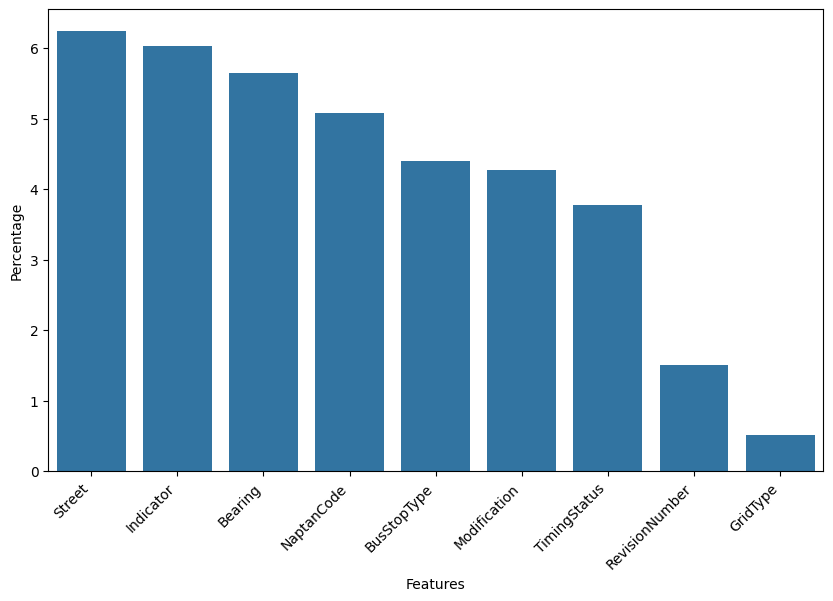

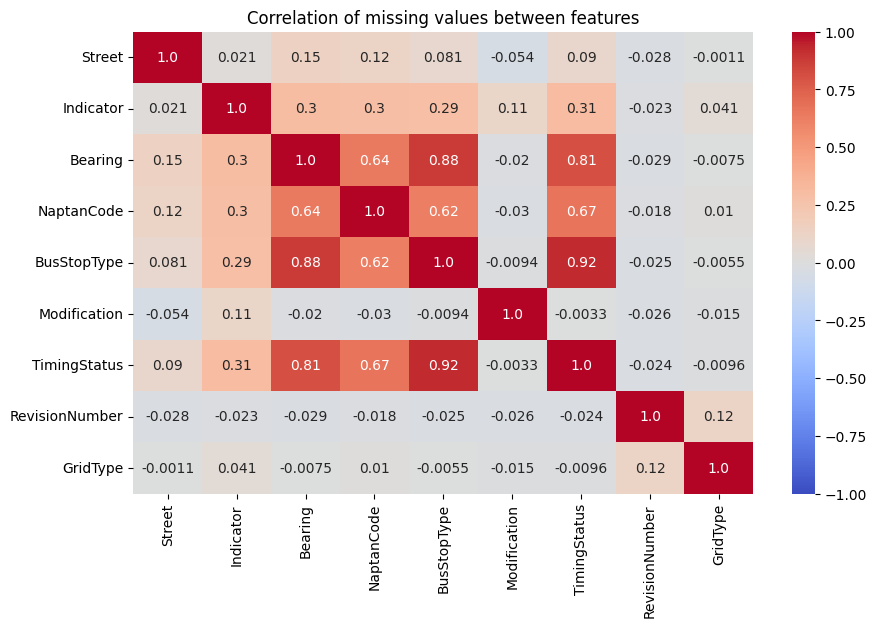

                  Street  Indicator   Bearing  NaptanCode  BusStopType  \
Street          1.000000   0.021304  0.147627    0.123257     0.081452   
Indicator       0.021304   1.000000  0.298404    0.295546     0.285089   
Bearing         0.147627   0.298404  1.000000    0.641451     0.876521   
NaptanCode      0.123257   0.295546  0.641451    1.000000     0.617923   
BusStopType     0.081452   0.285089  0.876521    0.617923     1.000000   
Modification   -0.054480   0.109361 -0.019838   -0.030213    -0.009447   
TimingStatus    0.089690   0.311587  0.809742    0.668234     0.923814   
RevisionNumber -0.027684  -0.022785 -0.028951   -0.017816    -0.025255   
GridType       -0.001117   0.040891 -0.007467    0.010417    -0.005514   

                Modification  TimingStatus  RevisionNumber  GridType  
Street             -0.054480      0.089690       -0.027684 -0.001117  
Indicator           0.109361      0.311587       -0.022785  0.040891  
Bearing            -0.019838      0.809742    

In [41]:
# Calculating the percentage of missing values
missing_values = stops_data.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)

# Displaying missing value percentages
print("Missing Value Analysis:")
print(missing_values)

# Visualising the missing values
plt.figure(figsize = (10, 6))
sns.barplot(x = missing_values.index, y = missing_values.values)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel("Percentage")
plt.xlabel("Features")
plt.show()

# Pairwise correlation for features with missing values
missing_features = missing_values.index
correlation_matrix = stops_data[missing_features].isnull().corr()

# Visualising the correlation of columns with missing values
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2", vmin = -1, vmax = 1)
plt.title("Correlation of missing values between features")
plt.show()

print(correlation_matrix)

#### Decisions from the Heatmap results
Based on findings from: https://www.gov.uk/government/publications/national-public-transport-access-node-schema/naptan-guide-for-data-managers
1. Street: An API would be needed for accurate imputation and the values are specific.
2. GridType: This is more of a reference to the geographic data or features, therefore, this will be dropped.
3. NaptanCode: This is an unique identifier for tracking stops. The missing values cannot be filled with imputation or modification.
4. BusStopType: KNN may be a good approach, as it is relevant for the first research question below.
5. Modification: This is vital for the second research question below, so it has to be kept.
6. TimingStatus: 

### 2nd Iteration Research Questions:

1. How is the distribution of Stop Types and Bus Stop Types differentiated between rural and urban area and how do they influence the accessibility of public transport?
2. What can be visualised about the frequency and timing of maintenance activities, as indicated by Date/Time of modifications, revision numbers and modification across different localities?
3. How do bus stop densities and types vary across Admin area codes and how do these variations be visualised to identify region that are not been being served as much?
4. What disparities exist between LocalityName, LocalityCentre, and their associated characteristics when visualised interactively?

### b. Columns and Data Types:
- The "LocalityCentre" column was converted to a bool, but there are many other features that need to be changed ton

1. Convert the following object types to category types to minimise the amount of memory being used: "ATCOCode", "NaptanCode", "CommonName", "Street", "Indicator", "Bearing", "StopType", "BusStopType", "Modification", "Status" and "GridType".
   - This is because the dataset is very large and will aid the project in terms of performance.

In [ ]:
# Converting categorical 'object' types to 'categorical' types
categorical_columns = ['ATCOCode', 'NaptanCode', 'CommonName', 'Street', 'Indicator', 'Bearing', 
                       'StopType', 'BusStopType', 'Modification', 'Status', 'GridType']
stops_data[categorical_columns] = stops_data[categorical_columns].astype('category')

# Converting datetime columns
stops_data['CreationDateTime'] = pd.to_datetime(stops_data['CreationDateTime'])
stops_data['ModificationDateTime'] = pd.to_datetime(stops_data['ModificationDateTime'])
